In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# INTRODUCTION

- Anomaly detection typically refers to the process of identifying outliers in a set of data that is largely composed of ‘normal’ data points.
- Typically, fraud transactions come from the uncommong transaction behavior. From this idea, it's great way to develop fraud detection based on data anomaly.

# Problems

- Most of the detection systems are based on rules. These systems, based on predefined rules pertaining to amounts, countries, or customer behaviors, are identified by fraudsters.

> But the main problem of this approximation is the system is fixed, which means it's easier to adapt their behaviors to bypass these rules
and manage to launder their money through illegal activities.
For these reasons, they generate a high false alerts rate and
detect few fraudulent transactions.


In [6]:
df = pd.DataFrame()
for c in range(20):
    temp = pd.read_csv(f"PaySim-log{c+1}.csv")
    df = pd.concat([temp, df])
    del temp

print(df.info())
print(df.shape)
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 6362620 entries, 0 to 318130
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 582.5+ MB
None
(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In this cases:
- The ‘isFraud’ column will provide us with ground truth values for whether transactions are fraudulent or not, against which our anomaly detection model can be evaluated.

- The naive rule that forms the basis for the ‘isFlaggedFraud’ column, namely that transactions with high amounts are more likely to be anomalies, shall be used as a baseline that represents an instance of hard-coded models, which we would like to improve upon.

**Feature Engineering**

In [12]:
features = pd.DataFrame(index=df.index)
numerical_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 
                     'oldbalanceDest', 'newbalanceDest']
features[numerical_columns] = df[numerical_columns]

In [13]:
features['changebalanceOrig'] = (features['newbalanceOrig'] 
                                 - features['oldbalanceOrg'])
features['changebalanceDest'] = (features['newbalanceDest']
                                 - features['oldbalanceDest'])
features['hour'] = df['step'] % 24

In [14]:
type_one_hot = pd.get_dummies(df['type'])
features = pd.concat([features, type_one_hot], axis=1)

**Modeling**

To function as a fraud detection system that is as general as possible, we want the following properties in our model:

- Makes no assumptions about what an anomaly looks like.
- Does not require any flagged data (labels).
- Provides a continuous anomaly score, such that the number of identified anomalies can be adjusted depending on the desired strictness.

In [15]:
from sklearn.ensemble import IsolationForest
forest = IsolationForest(random_state=0)
forest.fit(features)

IsolationForest(random_state=0)

In [16]:
scores = forest.score_samples(features)

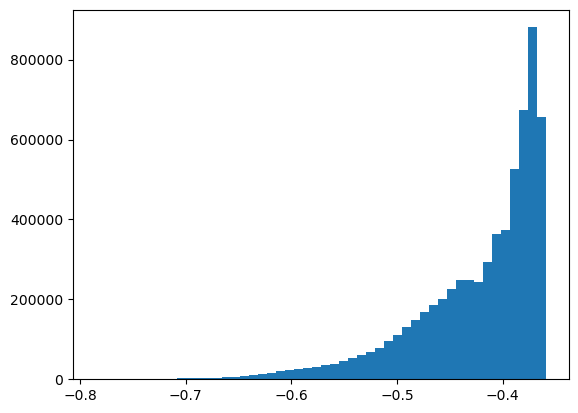

In [17]:
plt.hist(scores, bins=50)
plt.show()

ROC AUC Score: 0.88


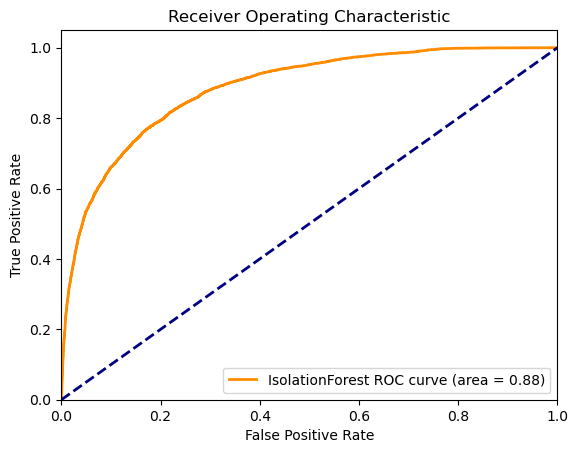

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve

iso_roc_auc = roc_auc_score(df['isFraud'], -1 * scores)
print(f'ROC AUC Score: {iso_roc_auc:.2f}')
iso_fpr, iso_tpr, iso_thresholds = roc_curve(df['isFraud'], -1 * scores)

# Plot both ROC curves
plt.figure()
plt.plot(iso_fpr, iso_tpr, color='darkorange', lw=2, label=f'IsolationForest ROC curve (area = {iso_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**Explanation Model**

Explanation using SHAP:

> SHAP values tell us how much each feature of the input contributed to that score, and in which direction (i.e. whether the feature contributed to a higher or a lower anomaly score).

In [22]:
from tqdm.autonotebook import tqdm, trange
import tqdm.notebook

# Initialize tqdm notebook mode
tqdm.notebook.tqdm.pandas()

C:\Users\Baha Tegar\AppData\Local\Temp\ipykernel_38708\2536920636.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [23]:
import shap
from tqdm.autonotebook import tqdm

explainer = shap.TreeExplainer(forest)

In [24]:
# Since the data is too large, it's good to simplify it by generate sample.
random_indices = np.random.choice(len(features), 5000)
shap_values_random = explainer.shap_values(features.iloc[random_indices, :])
random_features = features.iloc[random_indices, :]

### SHAP Force Plot Explanation:

#### 1. **Base Value:**
- The base value (or expected value) is the average model output over the training dataset. In the context of anomaly detection, it represents the average anomaly score.
- It is a reference point against which the individual SHAP values are measured.

#### 2. **Model Output Value:**
- The model output value is the predicted anomaly score for the specific data point you are analyzing.

#### 3. **SHAP Values:**
- SHAP values explain the contribution of each feature to the model's prediction for that specific data point.
- They show how much each feature is pushing the prediction from the base value to the actual model output value.

#### 4. **Bars in the Force Plot:**
- **Blue Bars (Negative SHAP Values):**
  - These bars represent features that contribute to lowering the anomaly score.
  - When a SHAP value is negative, it means that the feature is making it more likely that the data point is considered an anomaly.
  - In other words, these features are pulling the prediction down towards an anomaly.

- **Red Bars (Positive SHAP Values):**
  - These bars represent features that contribute to increasing the anomaly score.
  - When a SHAP value is positive, it means that the feature is making it less likely that the data point is considered an anomaly (i.e., it suggests the data point is more normal).
  - These features are pushing the prediction up away from being classified as an anomaly.

#### 5. **Sum of SHAP Values:**
- The sum of all SHAP values for a data point equals the difference between the base value and the model output value for that data point.
  - Mathematically: `Base Value + Sum of SHAP Values = Model Output Value`.
- This relationship ensures that the contributions of all features (SHAP values) explain the deviation of the model's prediction from the average prediction (base value).

### Example Breakdown:

Let's go through an example force plot to see how this works in practice.

1. **Base Value:** Suppose the base value is 0.5. This means the average anomaly score across the training set is 0.5.
2. **Model Output Value:** For a specific data point, the model output value is 0.7. This means the model predicts an anomaly score of 0.7 for this data point.

#### SHAP Values for the Data Point:

- Feature 1 (Red Bar, Positive SHAP Value): +0.1
- Feature 2 (Blue Bar, Negative SHAP Value): -0.2
- Feature 3 (Red Bar, Positive SHAP Value): +0.3

#### Calculations:

- Sum of SHAP Values = +0.1 - 0.2 + 0.3 = +0.2
- Base Value + Sum of SHAP Values = 0.5 + 0.2 = 0.7
- This matches the model output value of 0.7.

### Visual Interpretation:

- The red bars (Features 1 and 3) are pushing the score higher, suggesting these features make the data point appear more normal.
- The blue bar (Feature 2) is pulling the score lower, suggesting this feature makes the data point more anomalous.
- The combined effect of all features (SHAP values) explains why the model output is 0.7 instead of the average score of 0.5.

### Summary:

- **Blue Bars (Negative SHAP Values):** Features contributing to a lower score (more anomalous).
- **Red Bars (Positive SHAP Values):** Features contributing to a higher score (less anomalous).
- **Base Value:** Average model prediction across the dataset.
- **Model Output Value:** Actual prediction for the specific data point.
- **Sum of SHAP Values:** Explains the difference between the base value and the model output value.

This explanation helps understand how each feature influences the model's decision, providing transparency into the model's predictions.

In [25]:
# force_plot = shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test.iloc[0,:],link="logit")
force_plot = shap.force_plot(explainer.expected_value, shap_values_random[0, :],
                random_features.iloc[0, :])

from IPython.display import HTML
html_content = f"""
<div style='width: 100%; overflow-x: auto;'>
    {shap.getjs()}
    <div style='width: 2000px;'>
        {force_plot.html()}
    </div>
</div>
"""
HTML(html_content)

NOTE:
> One issue with the previous plot is the fact that the different values of the ‘type’ field are treated as separate features with binary values due to the one-hot-encoding we applied in the beginning. To solve this, we can simply undo the one-hot-encoding in the feature matrix and add all of the corresponding SHAP values to 1 single value.

### SHAP Dependence Plot

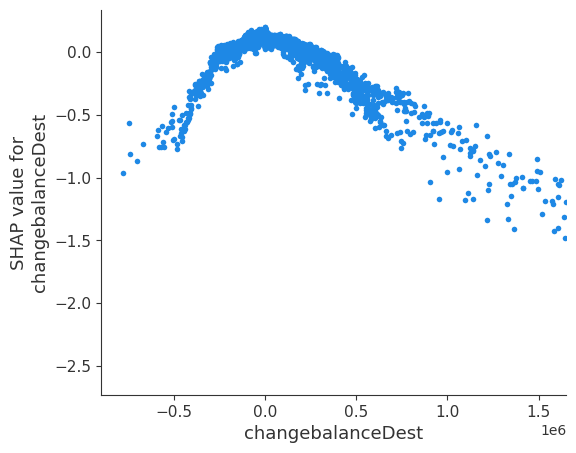

In [26]:
shap.dependence_plot(
 'changebalanceDest',
 shap_values_random,
 random_features,
 interaction_index=None,
 xmax='percentile(99)'
)

NOTES:
- We can see that the SHAP value of ‘changebalanceDest’ is positive for values close to zero, suggesting small changes in the receiver account’s balance are common.
- The more the absolute value increases, the more the SHAP value contributes to making the anomaly score lower (i.e. increasing the chance of being an anomaly).

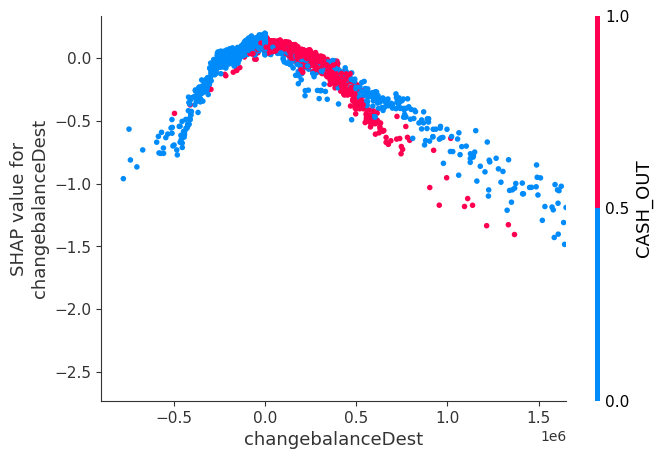

In [27]:
shap.dependence_plot(
 'changebalanceDest',
 shap_values_random,
 random_features,
 interaction_index='CASH_OUT',
 xmax='percentile(99)'
)

NOTES:
- It seems as though large sums of money become indicators for an anomaly more quickly if the ‘type’ field is equal to CASH_OUT.

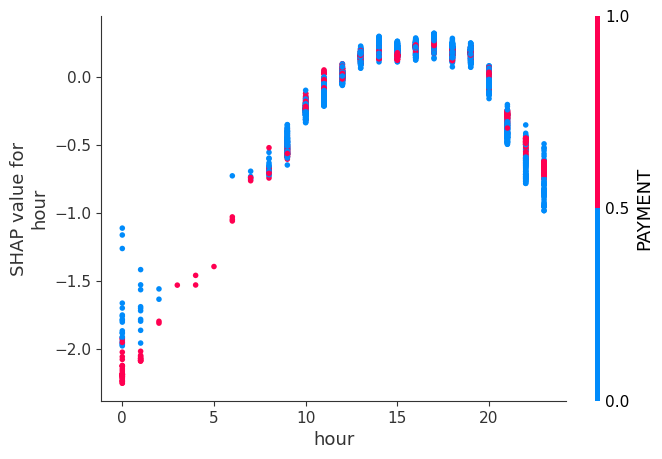

In [28]:
shap.dependence_plot(
 'hour',
 shap_values_random,
 random_features,
 interaction_index='PAYMENT',
 xmax='percentile(99)'
)

NOTES:
- While a ‘hour’ value between 0 and 5 is generally indicative of being an anomaly, this effect is more pronounced for transactions of the PAYMENT type. Interestingly, this effect is not there or even reversed during other times of the day.

Ref:
- https://medium.com/unit8-machine-learning-publication/a-guide-to-building-a-financial-transaction-anomaly-detector-480b07190620

- https://www.kaggle.com/datasets/ealaxi/paysim1